# **Final Project**

##### 0. Libary & setting

In [150]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import gym
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations


# multiple output in notebook without print()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


Parameters and Quantization Thresholds Setting

In [ ]:
# Parameters
M = 1.0  # Mass of the cart
m = 0.1  # Mass of the pole
g = -9.8  # Gravity
l = 0.5  # Length of the pole
mu_c = 0.0005  # Friction for the cart
mu_p = 0.000002  # Friction for the pole
delta_t = 0.02  # Time step
actions = [-10, 10]  # Available actions (forces in Newtons)

# Quantization thresholds
theta_boxes = np.array([-12, -6, -1, 0, 1, 6, 12]) * np.pi / 180  # radians
x_boxes = np.array([-2.4, -0.8, 0.8, 2.4])  # meters
theta_dot_boxes = np.array([-50, 0, 50]) * np.pi / 180  # radians/s, here we add 0 in quatization thresholds
x_dot_boxes = np.array([-0.5, 0, 0.5])  # m/s, here we add 0 in quatization thresholds 

In [ ]:
# Define state space size
state_space_size = (
    len(theta_boxes) + 1, 
    len(theta_dot_boxes) + 1, 
    len(x_boxes) + 1, 
    len(x_dot_boxes) + 1
)

# Dynamics model
def compute_accelerations(theta, theta_dot, x_dot, F):
    """Compute angular and linear accelerations based on the model."""
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    # sgn is signum function(np.sign)
    theta_ddot = (g*sin_theta + cos_theta*((-F - m*l*(theta_dot**2)*sin_theta + mu_c*np.sign(x_dot)) / (M + m)) - (mu_p*theta_dot /     (m*l))) / (l * (4/3 - m*cos_theta**2 / (M + m)))

    x_ddot = (
        F + m*l*(theta_dot**2 * sin_theta - theta_ddot * cos_theta)
        - mu_c * np.sign(x_dot)
    ) / (M + m)
    
    return theta_ddot, x_ddot

# Update state using Euler's method
def update_state(state, action):
    """Update the state using Euler integration"""
    theta, theta_dot, x, x_dot = state # state s = (theta, theta_dot, x, x_dot)
    F = action
    theta_ddot, x_ddot = compute_accelerations(theta, theta_dot, x_dot, F)
    x_dot += delta_t * x_ddot # update x_dot
    x += delta_t * x_dot # update x
    theta_dot += delta_t * theta_ddot # update theta_dot
    theta += delta_t * theta_dot # update theta
    
    return np.array([theta, theta_dot, x, x_dot])

# Discretize state based on provided thresholds
def discretize_state(state):
    """Discretizes a continuous state into discrete bins"""
    theta, theta_dot, x, x_dot = state
    # indices of the bins to which each state variable in threshold array
    theta_idx = np.digitize(theta, theta_boxes, right=True) 
    theta_dot_idx = np.digitize(theta_dot, theta_dot_boxes, right=True) 
    x_idx = np.digitize(x, x_boxes, right=True) 
    x_dot_idx = np.digitize(x_dot, x_dot_boxes, right=True) 
    
    return (theta_idx, theta_dot_idx, x_idx, x_dot_idx)


Policy iteration algorithm

In [177]:
# Policy Iteration (refer to class text book by Sutton and Barto)
# We use time discount factor gamma as 0.8 considering the computational benefits
def policy_iteration(gamma = 0.8, threshold = 1e-4):
    """Policy Iteration Algorithm with Policy Evaluation and Policy Improvement"""
    # Step 1: Initialization
    policy = np.random.choice(len(actions), size = state_space_size) # deterministic policy, 0 or 1 corresponding to -10, 10(N)
    value_function = np.zeros(state_space_size) # initial value functions

    # Step 2 & 3: Policy Evaluation and Policy Improvement
    while True:
        # Policy Evaluation
        while True:
            delta = 0 # initial delta
            for theta_idx in range(state_space_size[0]): 
                for theta_dot_idx in range(state_space_size[1]): 
                    for x_idx in range(state_space_size[2]): 
                        for x_dot_idx in range(state_space_size[3]): 
                            state = (theta_idx, theta_dot_idx, x_idx, x_dot_idx)
                            action = actions[policy[state]]
                            value = value_function[state]
                            new_value = 0

                            # Simulate transitions and rewards
                            for _ in range(10):  # Sample transitions
                                continuous_state = [                                    
                                    theta_boxes[theta_idx - 1] if theta_idx > 0 else -np.inf,
                                    theta_dot_boxes[theta_dot_idx - 1] if theta_dot_idx > 0 else -np.inf,
                                    x_boxes[x_idx - 1] if x_idx > 0 else -np.inf,
                                    x_dot_boxes[x_dot_idx - 1] if x_dot_idx > 0 else -np.inf
                                ]
                                next_state_continuous = update_state(continuous_state, action)
                                next_state = discretize_state(next_state_continuous)
                                
                                reward = 1 if abs(next_state_continuous[0]) <= 12 * np.pi / 180 and abs(next_state_continuous[2]) <= 2.4 else 0
                                new_value += reward + gamma * value_function[next_state]

                            new_value /= 10  # Average over samples
                            value_function[state] = new_value
                            delta = max(delta, abs(value - new_value))
            if delta < threshold:
                break

        # Policy Improvement
        policy_stable = True
        for theta_idx in range(state_space_size[0]):
            for theta_dot_idx in range(state_space_size[1]):
                for x_idx in range(state_space_size[2]):
                    for x_dot_idx in range(state_space_size[3]):
                        state = (theta_idx, theta_dot_idx, x_idx, x_dot_idx)
                        old_action = policy[state]
                        action_values = []

                        # Compute value for each action
                        for action_idx, action in enumerate(actions):
                            value = 0
                            for _ in range(10):  # Sample transitions                                    
                                continuous_state = [                                    
                                    theta_boxes[theta_idx - 1] if theta_idx > 0 else -np.inf,
                                    theta_dot_boxes[theta_dot_idx - 1] if theta_dot_idx > 0 else -np.inf,
                                    x_boxes[x_idx - 1] if x_idx > 0 else -np.inf,
                                    x_dot_boxes[x_dot_idx - 1] if x_dot_idx > 0 else -np.inf,
                                ]
                                next_state_continuous = update_state(continuous_state, action)
                                next_state = discretize_state(next_state_continuous)
                                # we difine reward as 1 for the success(keeping balance) and 0 for the failure
                                reward = 1 if abs(next_state_continuous[0]) <= 12 * np.pi / 180 and abs(next_state_continuous[2]) <= 2.4 else 0
                                value += reward + gamma * value_function[next_state]

                            value /= 10  # Average over samples
                            action_values.append(value)

                        best_action = np.argmax(action_values)
                        policy[state] = best_action
                        if old_action != best_action:
                            policy_stable = False

        if policy_stable:
            break

    return policy, value_function


Value Iteration Algorithm

In [ ]:
# Value Iteration (refer to class text book by Sutton and Barto)
# We use time discount factor gamma as 0.8 considering the computational benefits
def value_iteration(gamma = 0.8, threshold = 1e-4):
    # Step 1: Initialization
    value_function = np.zeros(state_space_size)
    policy = np.zeros(state_space_size, dtype=int)

    # Step 2: Value Iteration
    while True:
        delta = 0
        for theta_idx in range(state_space_size[0]):
            for theta_dot_idx in range(state_space_size[1]):
                for x_idx in range(state_space_size[2]):
                    for x_dot_idx in range(state_space_size[3]):
                        state = (theta_idx, theta_dot_idx, x_idx, x_dot_idx)
                        value = value_function[state]
                        action_values = []

                        # Compute value for each action
                        for action_idx, action in enumerate(actions):
                            new_value = 0
                            for _ in range(10):  # Sample transitions
                                continuous_state = [
                                    theta_boxes[theta_idx - 1] if theta_idx > 0 else -np.inf,
                                    theta_dot_boxes[theta_dot_idx - 1] if theta_dot_idx > 0 else -np.inf,
                                    x_boxes[x_idx - 1] if x_idx > 0 else -np.inf,
                                    x_dot_boxes[x_dot_idx - 1] if x_dot_idx > 0 else -np.inf,
                                ]
                                next_state_continuous = update_state(continuous_state, action)
                                next_state = discretize_state(next_state_continuous)
                                # we difine reward as 1 for the success(keeping balance) and 0 for the failure
                                reward = 1 if abs(next_state_continuous[0]) <= 12 * np.pi / 180 and abs(next_state_continuous[2]) <= 2.4 else 0
                                new_value += reward + gamma * value_function[next_state]

                            new_value /= 10  # Average over samples
                            action_values.append(new_value)

                        # Update value function and policy
                        value_function[state] = max(action_values)
                        policy[state] = np.argmax(action_values)
                        delta = max(delta, abs(value - value_function[state]))

        if delta < threshold:
            break

    return policy, value_function

Algorithm Implementation and Plotting

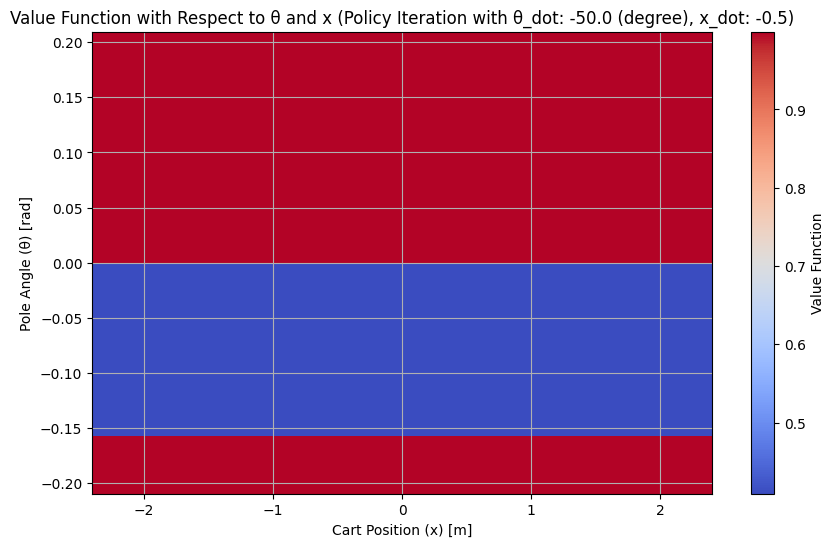

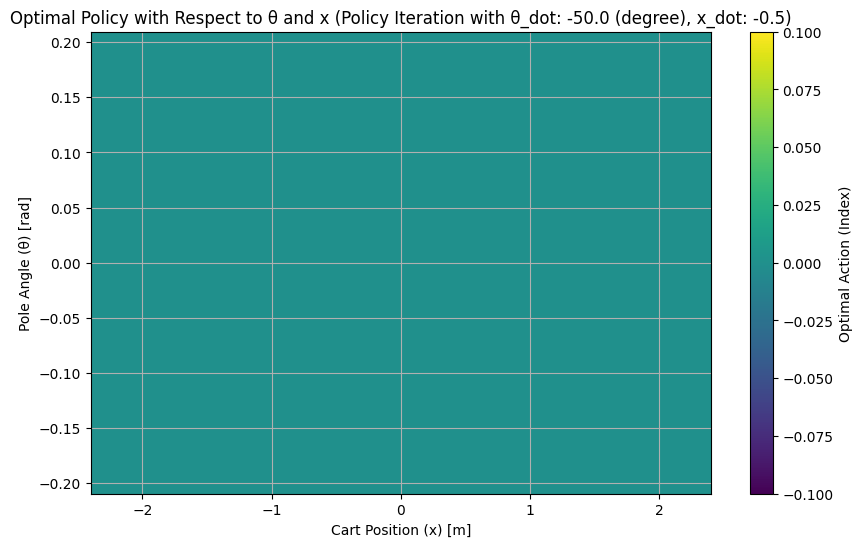

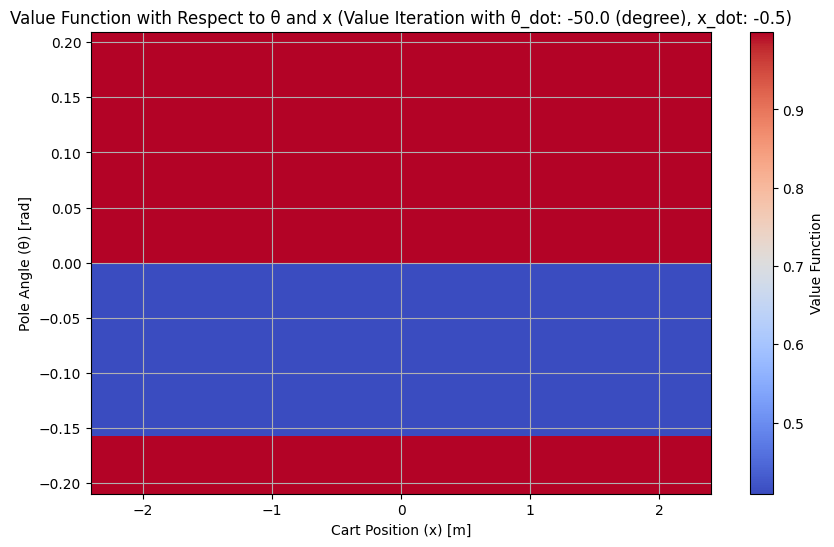

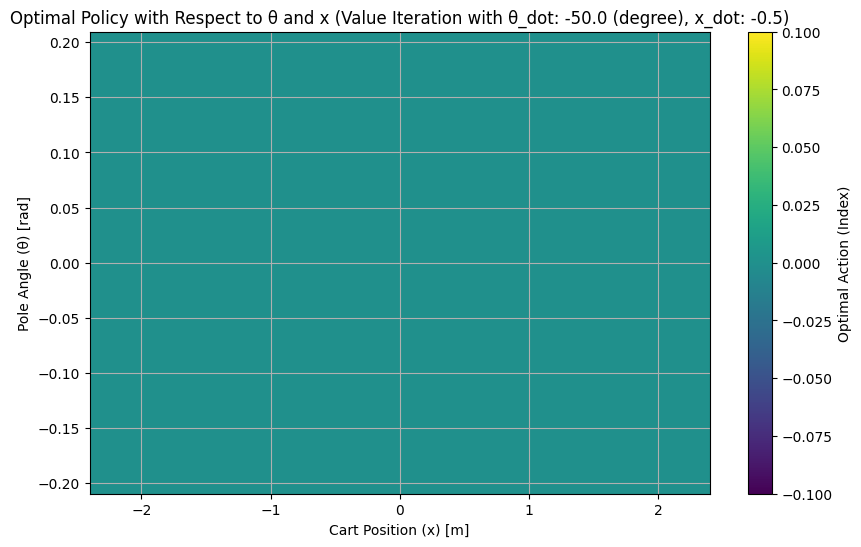

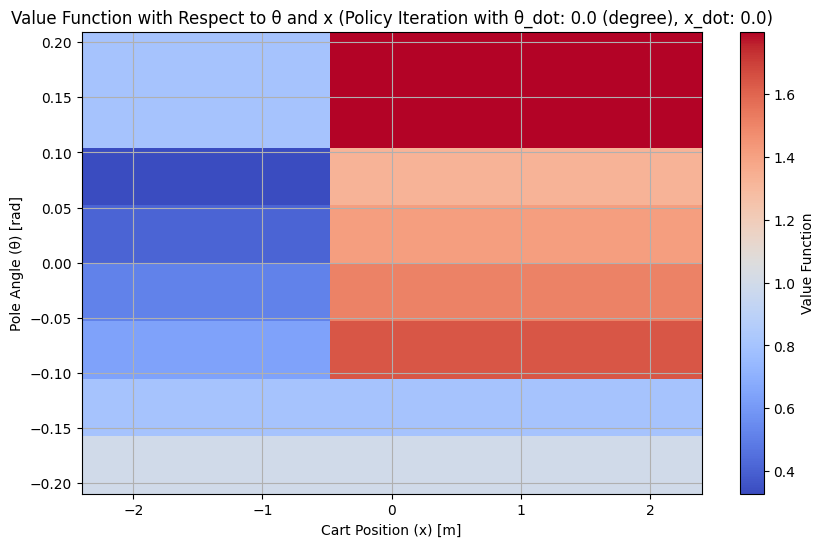

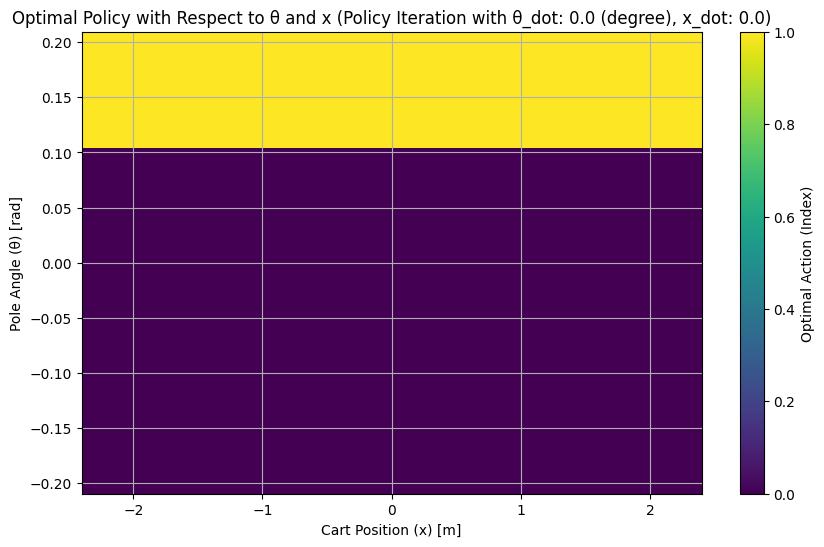

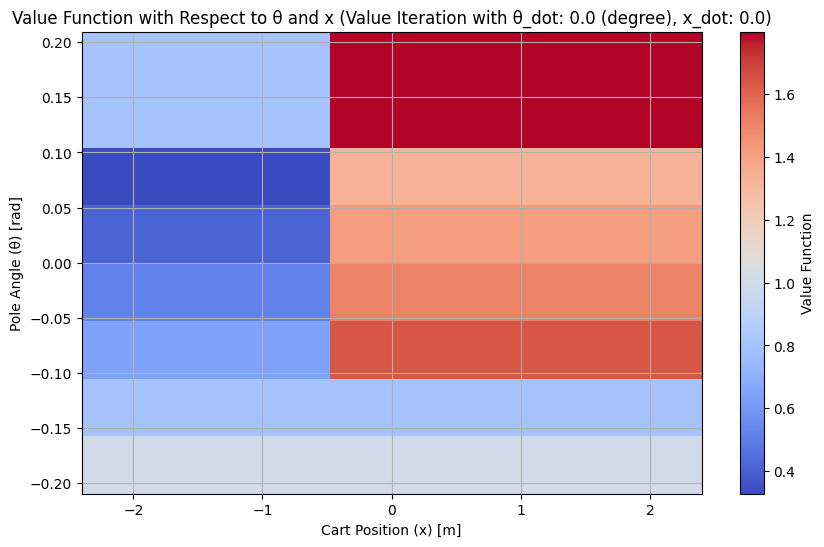

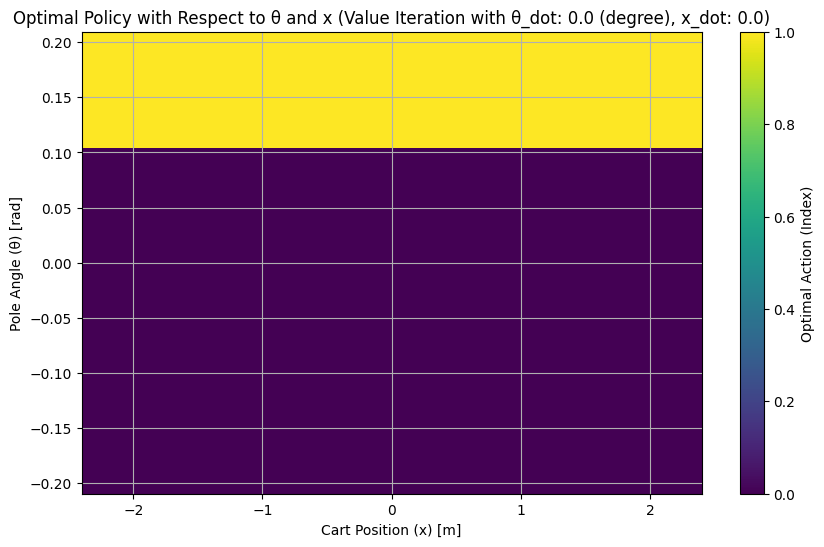

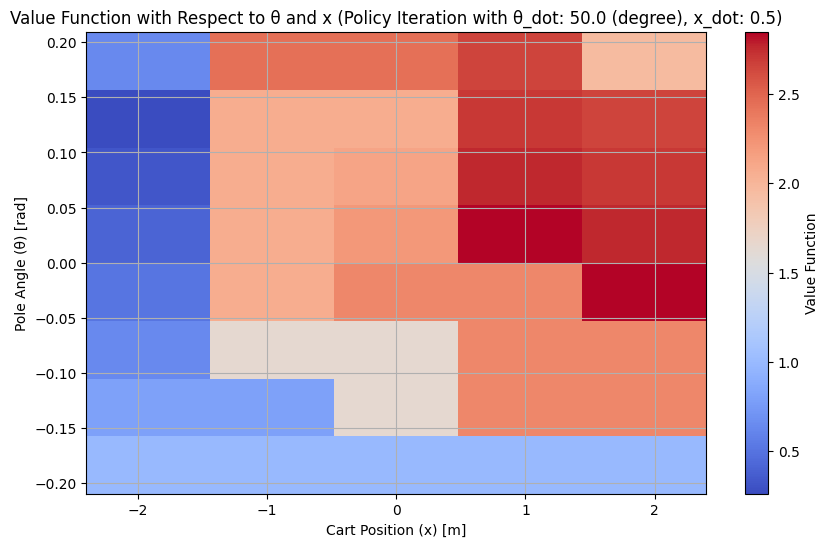

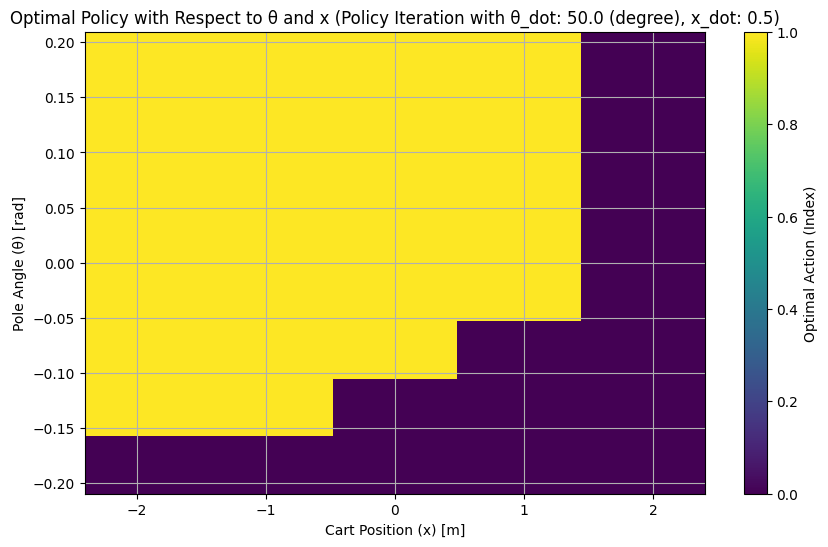

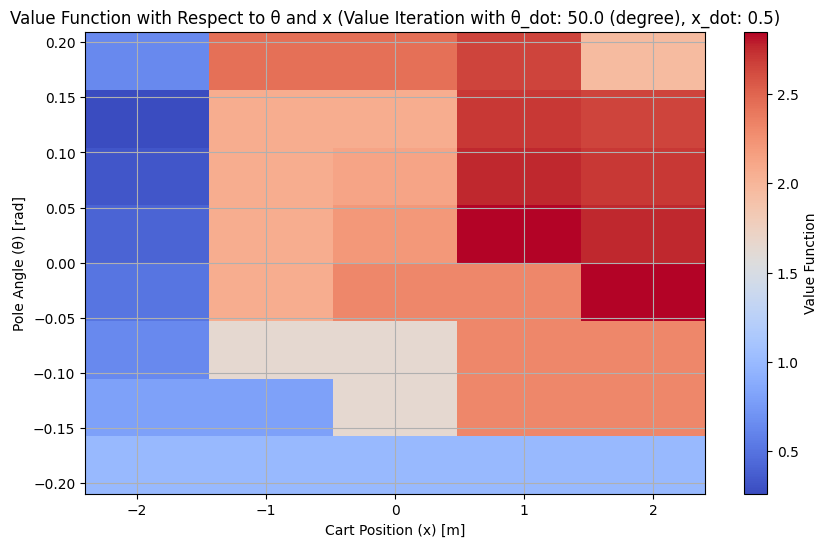

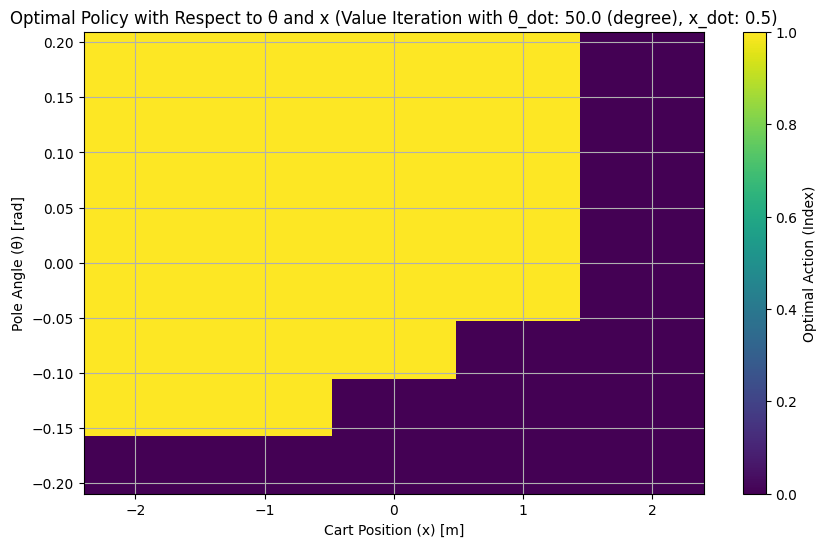

In [ ]:
## Define function for plotting value function w.r.t theta and x for selected theta_dot and x_dot
def plot_value_function(value_function, method_name, fixed_theta_dot_idx, fixed_x_dot_idx):
    """Plots the value function with respect to θ and x."""
    value_function_slice = value_function[:, fixed_theta_dot_idx, :, fixed_x_dot_idx]
    plt.figure(figsize=(10, 6))
    plt.imshow(
        value_function_slice,
        extent=[x_boxes[0], x_boxes[-1], theta_boxes[0], theta_boxes[-1]],
        aspect='auto',
        origin='lower',
        cmap="coolwarm",
    )
    plt.colorbar(label="Value Function")
    plt.title(f"Value Function with Respect to θ and x ({method_name})")
    plt.xlabel("Cart Position (x) [m]")
    plt.ylabel("Pole Angle (θ) [rad]")
    plt.grid()
    plt.show()

## Define function for plotting optimal policy w.r.t theta and x for selected theta_dot and x_dot
def plot_optimal_policy(policy, method_name, fixed_theta_dot_idx, fixed_x_dot_idx):
    """Plots the optimal policy with respect to θ and x."""
    policy_slice = policy[:, fixed_theta_dot_idx, :, fixed_x_dot_idx]
    plt.figure(figsize=(10, 6))
    plt.imshow(
        policy_slice,
        extent=[x_boxes[0], x_boxes[-1], theta_boxes[0], theta_boxes[-1]],
        aspect='auto',
        origin='lower',
        cmap="viridis",
    )
    plt.colorbar(label="Optimal Action (Index)")
    plt.title(f"Optimal Policy with Respect to θ and x ({method_name})")
    plt.xlabel("Cart Position (x) [m]")
    plt.ylabel("Pole Angle (θ) [rad]")
    plt.grid()
    plt.show()
    
# Implement the policy_iteration, value_iteration algorithms
policy_pi, value_function_pi = policy_iteration()
policy_vi, value_function_vi = value_iteration()


## Plotting
# Define three different combinations of fixed θ_dot and x_dot
fixed_combinations = [
    (0,0),  # Minimum values of θ_dot and x_dot
    (1, 1),  # Midpoind of both
    (2, 2)  # Maximum values of θ_dot and x_dot
]

# Generate and plot value functions and optimal policies for each combination of fixed θ_dot and x_dot
for i, (fixed_theta_dot_idx, fixed_x_dot_idx) in enumerate(fixed_combinations):
    # Plot results for Policy Iteration
    plot_value_function(value_function_pi,
                        f"Policy Iteration with θ_dot: {theta_dot_boxes[fixed_theta_dot_idx]*180/np.pi} (degree), x_dot: {x_dot_boxes[fixed_x_dot_idx]}",
                        fixed_theta_dot_idx,
                        fixed_x_dot_idx)
    
    plot_optimal_policy(policy_pi,
                        f"Policy Iteration with θ_dot: {theta_dot_boxes[fixed_theta_dot_idx]*180/np.pi} (degree), x_dot: {x_dot_boxes[fixed_x_dot_idx]}",
                        fixed_theta_dot_idx,
                        fixed_x_dot_idx)

    # Plot results for Value Iteration
    plot_value_function(value_function_vi,
                        f"Value Iteration with θ_dot: {theta_dot_boxes[fixed_theta_dot_idx]*180/np.pi} (degree), x_dot: {x_dot_boxes[fixed_x_dot_idx]}",
                        fixed_theta_dot_idx,
                        fixed_x_dot_idx)
    
    plot_optimal_policy(policy_vi,
                        f"Value Iteration with θ_dot: {theta_dot_boxes[fixed_theta_dot_idx]*180/np.pi} (degree), x_dot: {x_dot_boxes[fixed_x_dot_idx]}",
                        fixed_theta_dot_idx,
                        fixed_x_dot_idx)
